In [1]:
import pandas as pd
import json
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm

### Labeling the data
We used [Encord](https://encord.com) to annotate our dataset, marking regions within the tiles using **polygons** assigned one of two labels: `solar_panel` or `unsure`.

### Data import and cleaning
The labeled data was exported in a `.json` format file. Only a subset of a the fields in the file are necessary for our model namely:
- `dataset_title`: The seed used to generate the tile
- `data_title`: The name of the tile
- `polygon`: The vertices of the polygons covering the solar panels
- `value`: the label of the polygon (**solar_panel** or **unsure**)

We will convert the labeled data into a `pandas` Dataframe and while only keeping these fields.

In [2]:
def load_labels(seed: int) -> pd.DataFrame:
    """
    Load the labels for a given seed.

    Args:
        seed (int): The seed of the dataset.
    Returns:
        pd.DataFrame: The labels for the dataset.
    """

    file_path = f"../data/labels/LABELS_SEED_{seed}.json"
    with open(file_path, "r") as f:
        data = json.load(f)

    extracted_data = []
    for entry in data:
        seed = entry.get("dataset_title")
        data_title = entry.get("data_title")
        data_units = entry.get("data_units", {})

        for unit in data_units.values():
            labels = unit.get("labels", {})
            objects = labels.get("objects", [])

            polygons = []
            values = []
            for obj in objects:
                polygons.append(obj.get("polygon"))
                values.append(obj.get("value"))

            if len(polygons) == 0:
                polygons = [None]
                values = [None]

            for polygon, value in zip(polygons, values):
                extracted_data.append(
                    {
                        "seed": seed,
                        "data_title": data_title,
                        "polygon": polygon,
                        "value": value,
                    }
                )

    return pd.DataFrame(extracted_data)


labels_seed_1 = load_labels(1)
labels_seed_1

,seed,data_title,polygon,value
0,Tiles seed=1,swissimage-dop10_2024_2625.9-1232.8.jpg,None,None
1,Tiles seed=1,swissimage-dop10_2024_2611.1-1238.2.jpg,"{'0': {'x': 0.13877326474668183, 'y': 1}, '1':...",solar_panel
2,Tiles seed=1,swissimage-dop10_2021_2610.2-1149.4.jpg,None,None
3,Tiles seed=1,swissimage-dop10_2021_2708.0-1095.2.jpg,"{'0': {'x': 0.4508513743272538, 'y': 0.6846210...",solar_panel
4,Tiles seed=1,swissimage-dop10_2021_2708.0-1095.2.jpg,"{'0': {'x': 0.644416529442688, 'y': 0.79247189...",solar_panel
...,...,...,...,...
649,Tiles seed=1,swissimage-dop10_2024_2625.0-1232.1.jpg,"{'0': {'x': 0.5658760235806427, 'y': 0.9439394...",solar_panel
650,Tiles seed=1,swissimage-dop10_2024_2625.0-1232.1.jpg,"{'0': {'x': 0.5393055930823386, 'y': 0.9982774...",solar_panel
651,Tiles seed=1,swissimage-dop10_2024_2625.0-1232.1.jpg,"{'0': {'x': 0.5377235997820866, 'y': 0.9987478...",solar_panel
652,Tiles seed=1,swissimage-dop10_2024_2625.0-1232.1.jpg,"{'0': {'x': 0.3972810787641705, 'y': 0.9993728...",solar_panel


Let's check the number of tiles that have no polygons, meaning that they do not contain any solar panels

In [3]:
print(f"There are {labels_seed_1.isna().sum()["polygon"]} tiles that have no polygons.")

There are 114 tiles that have no polygons.


The next step is to create the **mask** for each image indicating the position of the solar pannels.

In [4]:
def create_mask(df: pd.DataFrame, image_size=(1000, 1000), target_value="solar_panel") -> dict:
    """
    Create segmentation masks for images with labeled polygons.

    Args:
        df (pd.DataFrame): DataFrame containing `data_title`, `polygon`, and `value`.
        image_size (tuple): Dimensions of the image (width, height).
        target_value (str): Value to filter polygons for masking (e.g., "solar_panel").

    Returns:
        dict: Dictionary with `data_title` as keys and 1D numpy arrays (segmentation masks) as values.
    """
    masks = {}

    for _, row in df.iterrows():
        if row["value"] == target_value:
            mask = Image.new("L", image_size, 0)  
            draw = ImageDraw.Draw(mask)

            polygon = row["polygon"]
            polygon_points = [
                (vertex["x"] * image_size[0], vertex["y"] * image_size[1])
                for vertex in polygon.values()
            ]

            # Draw the polygon on the mask
            draw.polygon(polygon_points, outline=1, fill=1)
            mask_array = np.array(mask).flatten()

            if row["data_title"] not in masks:
                masks[row["data_title"]] = mask_array
            else:
                masks[row["data_title"]] = masks[row["data_title"]] + mask_array

        else:
            # if no polygon is found, create an empty mask
            masks[row["data_title"]] = np.zeros(image_size[0] * image_size[1])

    # Clip the mask values to ensure that they are either 0 or 1 when polygons overlap
    masks = {k: np.clip(v, 0, 1) for k, v in masks.items()}
    return masks


masks_seed_1 = create_mask(labels_seed_1)

As a sanity check, let's superpose the masks on top of their correponding pictures to make sure the `create_mask` function works as intended.

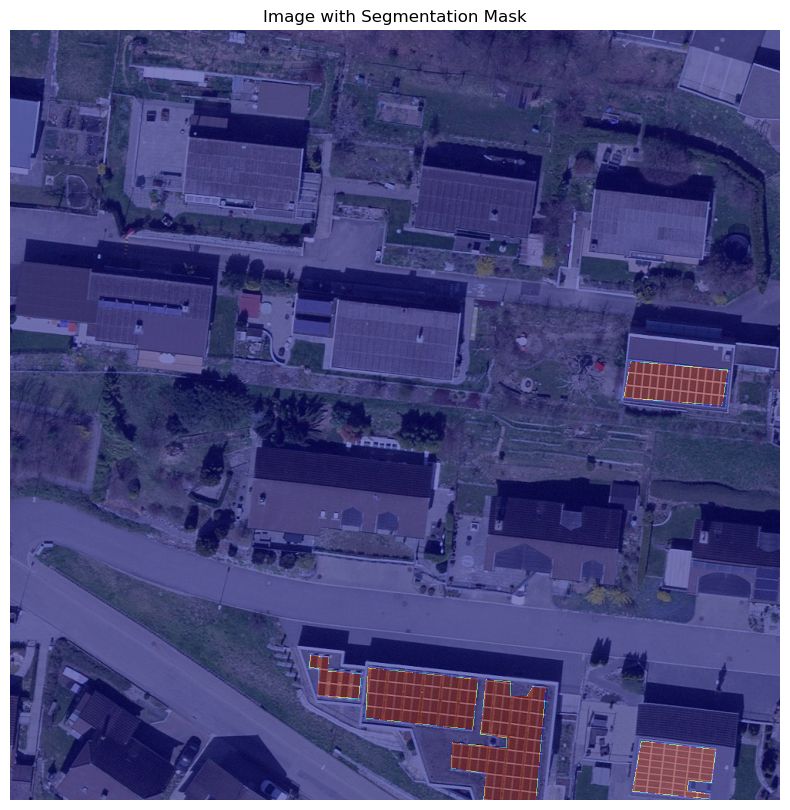

In [5]:
def plot_mask_on_image(image_path: str , mask: dict, image_size=(1000, 1000), alpha=0.5):
    """
    Plots a segmentation mask on top of an image.

    Args:
        image_path (str): Path to the original image file.
        mask (np.ndarray): 1D numpy array (flattened) representing the segmentation mask.
        image_size (tuple): Dimensions of the image (width, height).
        alpha (float): Transparency level of the mask overlay (0 to 1).
    """
    mask_2d = mask.reshape(image_size)
    image = Image.open(image_path).resize(image_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.imshow(mask_2d, cmap='jet', alpha=alpha) 
    plt.axis('off')
    plt.title("Image with Segmentation Mask")
    plt.show()


empty_image = "swissimage-dop10_2021_2610.0-1149.9.jpg"
filled_image = "swissimage-dop10_2021_2642.9-1226.3.jpg"
empty_image_path = "../data/sample/1/"+ empty_image
filled_image_path = "../data/sample/1/"+ filled_image

segmentation_mask = masks_seed_1[filled_image]
plot_mask_on_image(filled_image_path, segmentation_mask)


### Model

In [30]:
class SolarPanelDataset(Dataset):
    def __init__(self, image_dir, image_names, masks, transform=None):
        self.image_dir = image_dir
        self.image_names = image_names
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_names[idx])
        image = Image.open(image_path).convert("RGB")
        mask = self.masks[idx].reshape(1000, 1000)  
        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask


In [31]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

image_names = np.array(list(masks_seed_1.keys()))[:100]
masks = np.array(list(masks_seed_1.values()))[:100]

dataset = SolarPanelDataset("../data/sample/1/", image_names, masks, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


In [32]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=2, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [33]:
model = UNet()
criterion = nn.BCELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 4
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    print(f"Validation Loss: {val_loss/len(val_loader):.4f}")

100%|██████████| 10/10 [06:09<00:00, 36.92s/it]


Epoch 1/4, Loss: 0.4512
Validation Loss: 0.1961


100%|██████████| 10/10 [06:39<00:00, 39.99s/it]


Epoch 2/4, Loss: 0.0882
Validation Loss: 0.0460


100%|██████████| 10/10 [06:30<00:00, 39.04s/it]


Epoch 3/4, Loss: 0.0651
Validation Loss: 0.0547


100%|██████████| 10/10 [09:00<00:00, 54.02s/it]


Epoch 4/4, Loss: 0.0629
Validation Loss: 0.0465


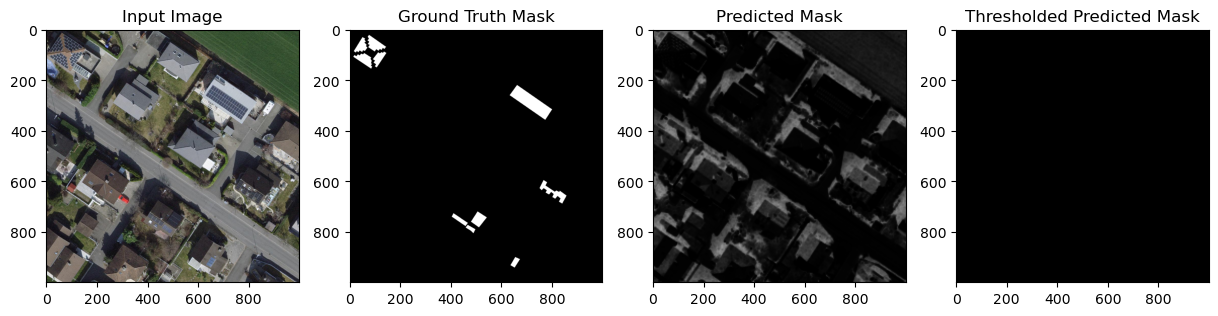

In [43]:
model.eval()
sample_image, sample_mask = dataset[5]
sample_image = sample_image.unsqueeze(0).to(device)

with torch.no_grad():
    prediction = model(sample_image)

input_image = sample_image.cpu().squeeze().permute(1, 2, 0)
ground_truth_mask = sample_mask.cpu().squeeze()
predicted_mask = prediction.cpu().squeeze()

threshold = 1
binary_predicted_mask = (predicted_mask > threshold)

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.title("Input Image")
plt.imshow(input_image)
plt.subplot(1, 4, 2)
plt.title("Ground Truth Mask")
plt.imshow(ground_truth_mask, cmap="gray")
plt.subplot(1, 4, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap="gray")
plt.subplot(1, 4, 4)
plt.title("Thresholded Predicted Mask")
plt.imshow(binary_predicted_mask, cmap="gray")
plt.show()

In [44]:
binary_predicted_mask

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])